# Paper Information

## Few-shot cross-domain image generation via inference-time latent-code learning
- https://openreview.net/pdf?id=sCYXJr3QJM8
- Appeared at ICLR 2023

## Group Members
- Erce Güder: guder.erce@metu.edu.tr
- Adnan Harun Doğan: adnan.dogan@metu.edu.tr

## Necessary imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import Generator, Discriminator
from latent_learner import LatentLearner
from dataset import Dataset
from tqdm import tqdm
from PIL import Image
import loss
import random
import utils
import torch
import torchvision

import numpy as np

import gc
import os

/home/ceng796/miniconda3/envs/796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reproducibility

In [3]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

## Hyper-parameters

In [4]:
resolution = 256
w_size = 512
n_mlp = 8

adv_bs = 4
style_bs = 5
lr = 5e-4

max_iters = 60
no_experiments = 3

g_loss_coeff = lambda x: 5 * (1 - x/max_iters)
style_loss_coeff = 50

sample_freq = 50

## Training and saving a model

In [5]:
def train(exp, device, n_imgs=10):
    generator = Generator(size=resolution, style_dim=w_size, n_mlp=n_mlp).to(device)
    discriminator = Discriminator(size=resolution).to(device)
    latent_learner = LatentLearner().to(device)

    vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()

    # No need for gradients on the parameters of these
    utils.disable_grad(generator)
    utils.disable_grad(vgg)

    # Take sub-networks from the vgg, later used to compute style loss
    subnetworks = loss.subnetworks(vgg, max_layers=5)

    # Garbage collection
    del vgg
    gc.collect()
    torch.cuda.empty_cache()

    # Load checkpoint and weights
    ckpt = torch.load("550000.pt")

    generator.load_state_dict(ckpt["g_ema"], strict=False)
    generator.eval()

    discriminator.load_state_dict(ckpt["d"])

    # Initialize optimizers (no optimizer for generator :)
    disc_opt = torch.optim.Adam(
        discriminator.parameters(),
        lr = lr,
        betas = (0.0, 0.99)
    )
    latent_learner_opt = torch.optim.Adam(
        latent_learner.parameters(),
        lr = lr,
        betas = (0.0, 0.99)
    )

    # Simple transformation pipeline
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((resolution, resolution)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # style loss normalization
    style_norm = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Create simple dataset & loader
    dataset = Dataset(path="./babies", transforms=transforms)

    bar = tqdm(range(max_iters), dynamic_ncols=True)

    # training loop
    for iter_ in bar:
        idx = np.random.choice(n_imgs, size=adv_bs, replace = adv_bs>n_imgs)

        imgs, latents = dataset[idx]
        imgs, latents = imgs.to(device), latents.to(device)

        ########## Adversarial Loss ##########
        # first forward pass
        w = latent_learner(latents)
        samples, _ = generator([w], input_is_latent=True)

        real_scores = discriminator(imgs)
        fake_scores = discriminator(samples)

        d_loss = loss.d_logistic_loss(real_scores, fake_scores)

        # optimization step on discriminator
        disc_opt.zero_grad()
        d_loss.backward()
        disc_opt.step()

        # second forward pass (needed)
        w = latent_learner(latents)
        samples, _ = generator([w], input_is_latent=True)

        fake_scores = discriminator(samples)

        g_loss = g_loss_coeff(iter_) * loss.g_nonsaturating_loss(fake_scores)

        # optimization step on latent learner
        latent_learner_opt.zero_grad()
        g_loss.backward()
        latent_learner_opt.step()

        ########## Style Loss ##########
        idx = np.random.choice(n_imgs, size=style_bs, replace = style_bs>n_imgs)

        imgs, latents = dataset[idx]
        imgs, latents = imgs.to(device), latents.to(device)

        w = latent_learner(latents)

        samples, _ = generator([w], input_is_latent=True)

        style_loss = style_loss_coeff * loss.style_loss(subnetworks, style_norm(imgs), style_norm(samples))

        latent_learner_opt.zero_grad()
        style_loss.backward()
        latent_learner_opt.step()

        bar.set_description(f"d_loss: {d_loss.cpu():.2f}, g_loss: {g_loss.cpu():.2f}, style_loss: {style_loss:.2f}")

        if (iter_+1) % sample_freq == 0:
            utils.save_samples(exp, dataset.x.to(device), generator, latent_learner, exp)

    return dataset.x.to(device), latent_learner, generator

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
for experiment in range(no_experiments):
    noise, latent_learner, generator = train(experiment, device, n_imgs=10)
    utils.save(experiment, generator, latent_learner, noise)

d_loss: 0.06, g_loss: 0.34, style_loss: 1.38: 100%|█████████████████████████████████████| 60/60 [00:57<00:00,  1.05it/s]


## Loading pre-trained models and computing qualitative samples/outputs

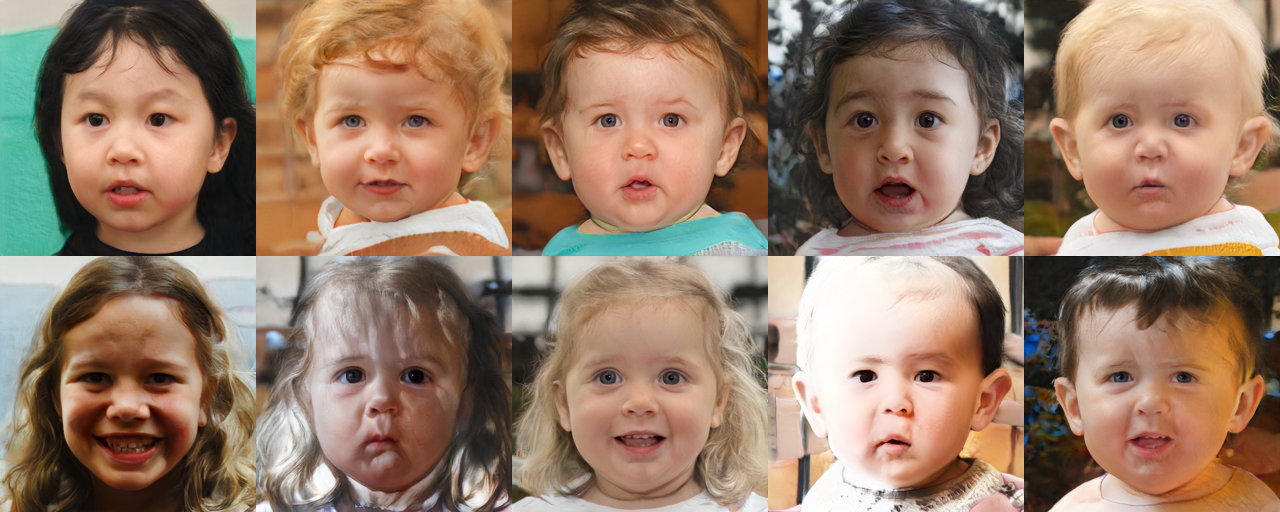

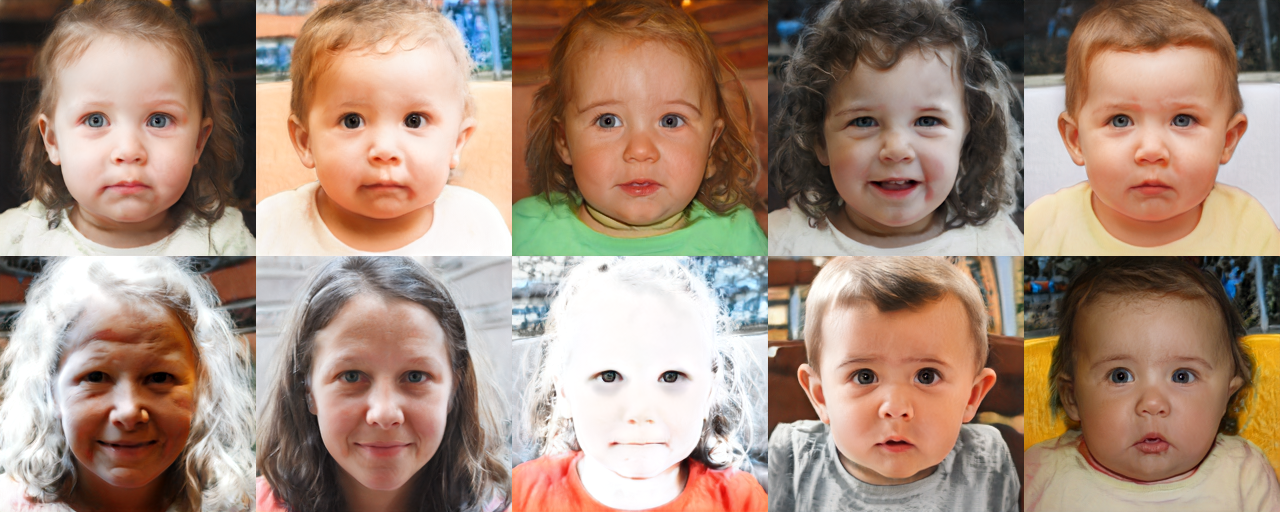

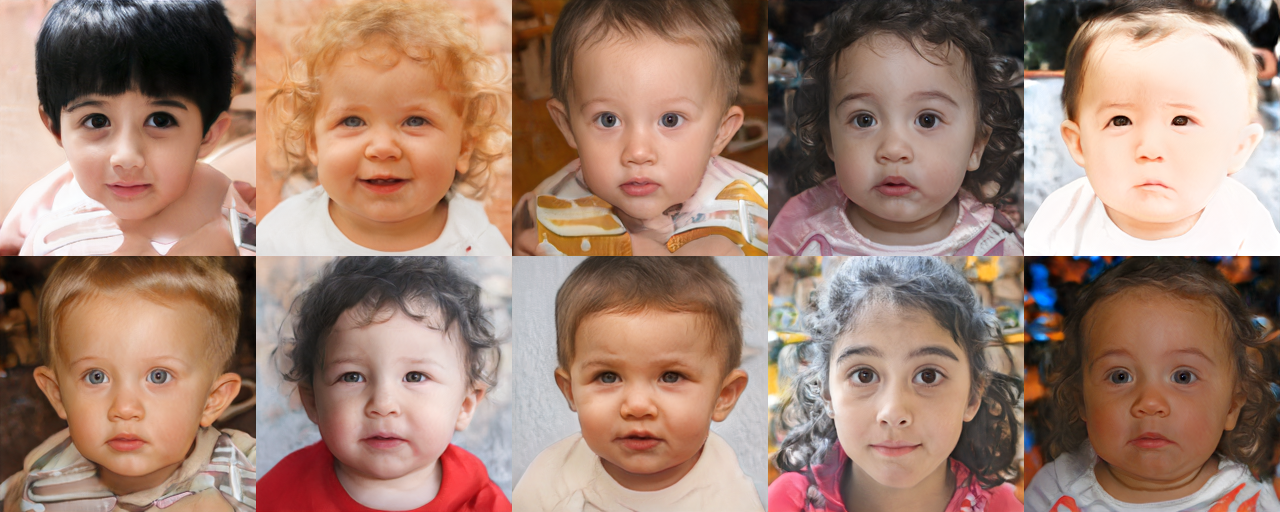

In [8]:
with torch.no_grad():
    for experiment in range(no_experiments):
        generator = Generator(size=resolution, style_dim=w_size, n_mlp=n_mlp).to(device)
        generator.load_state_dict(torch.load(f"ckpts/generator_{experiment}.pt"))
        generator.eval()

        latent_learner = LatentLearner().to(device)
        latent_learner.load_state_dict(torch.load(f"ckpts/latent_learner_{experiment}.pt"))

        noise = torch.load(f"ckpts/noise_{experiment}.pt")

        generator.eval()
        latent_learner.eval()

        w = latent_learner(noise)
        samples, _ = generator([w], input_is_latent=True)

        imgs = utils.tensor_to_img(samples)

        display(utils.image_grid(imgs, 2, 5))

In [9]:
# Garbage collect
del generator, latent_learner, noise
gc.collect()
torch.cuda.empty_cache()

## Quantitative Results

In [ ]:
!python -m pytorch_fid babies_test/ samples/ --device cuda:0

 38%|████████████████▎                          | 19/50 [00:03<00:03,  9.71it/s]

## Challenges

The main challenge for us was that the equations and algorithms described in the paper were *misleading*. For example,
 - The adversarial loss described in Equation 3 cannot be applied to StyleGAN2, as the discriminator output is not necessarily a probability.
     - To resolve this conflict, we had to have a look at their original repository.
 - It is stated that style loss in Equation 2 is taken from the original style loss paper, and that the notations are directly the same. However,
     - There are clearly conflicts between the paper introducing style loss and this paper.
     - Further, even the original repository of this paper does not use what is described to be used.